In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [3]:
tf.random.set_seed(23)

In [4]:
img_df = pd.read_csv("photos/image_labels.csv")
img_df.head()

,path,class,label,image_id
0,one_1.jpg,one,0,11
1,one_10.jpg,one,0,11
2,one_11.jpg,one,0,11
3,one_12.jpg,one,0,11
4,one_13.jpg,one,0,11


In [5]:
len(img_df)

992

### Resize images

In [7]:
from PIL import Image

(new_width, new_height) = (128, 128)

path = "photos/original/"
filenames = img_df["path"]

for filename in filenames:
    with Image.open(f"{path}/{filename}") as im:
        width, height = im.size
        if height >= width:
            left = 0
            top = (height-width)/2
            right = width
            bottom = width+(height-width)/2
        else:
            left = (width-height)/2
            top = 0
            right = height+(width-height)/2
            bottom = height
        im_cropped = im.crop((left, top, right, bottom))
        im_resized = im_cropped.resize((new_width, new_height), resample=Image.HAMMING)
        im_resized.save(f"photos/resized/128/{filename}")

### Create dataset

In [33]:
filenames = img_df["path"]
labels = img_df["label"]
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [34]:
def decode_images(file):
  path = f"./photos/resized/128/{file}"
  print(path)
  image_decoded = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)/255
  im = tf.cast(image_decoded, tf.float32)
  return im

decoded_images = list(map(lambda file: decode_images(file), list(filenames)))

./photos/resized/224/one_1.jpg
./photos/resized/224/one_10.jpg
./photos/resized/224/one_11.jpg
./photos/resized/224/one_12.jpg
./photos/resized/224/one_13.jpg
./photos/resized/224/one_14.jpg
./photos/resized/224/one_15.jpg
./photos/resized/224/one_16.jpg
./photos/resized/224/one_17.jpg
./photos/resized/224/one_18.jpg
./photos/resized/224/one_19.jpg
./photos/resized/224/one_2.jpg
./photos/resized/224/one_20.jpg
./photos/resized/224/one_21.jpg
./photos/resized/224/one_22.jpg
./photos/resized/224/one_23.jpg
./photos/resized/224/one_24.jpg
./photos/resized/224/one_25.jpg
./photos/resized/224/one_26.jpg
./photos/resized/224/one_27.jpg
./photos/resized/224/one_28.jpg
./photos/resized/224/one_29.jpg
./photos/resized/224/one_3.jpg
./photos/resized/224/one_30.jpg
./photos/resized/224/one_31.jpg
./photos/resized/224/one_32.jpg
./photos/resized/224/one_4.jpg
./photos/resized/224/one_5.jpg
./photos/resized/224/one_6.jpg
./photos/resized/224/one_7.jpg
./photos/resized/224/one_8.jpg
./photos/resized

In [35]:
print(decoded_images[1])

tf.Tensor(
[[[0.5882353  0.50980395 0.48235294]
  [0.58431375 0.5058824  0.47843137]
  [0.58431375 0.5058824  0.47843137]
  ...
  [0.7882353  0.8352941  0.827451  ]
  [0.84313726 0.8901961  0.88235295]
  [0.88235295 0.92941177 0.9137255 ]]

 [[0.58431375 0.5058824  0.47843137]
  [0.58431375 0.5058824  0.47843137]
  [0.5803922  0.5019608  0.4745098 ]
  ...
  [0.8862745  0.93333334 0.93333334]
  [0.90588236 0.9529412  0.94509804]
  [0.9098039  0.95686275 0.9490196 ]]

 [[0.58431375 0.5058824  0.47843137]
  [0.5803922  0.5019608  0.4745098 ]
  [0.5803922  0.5019608  0.4745098 ]
  ...
  [0.972549   1.         1.        ]
  [0.972549   1.         1.        ]
  [0.95686275 0.99607843 1.        ]]

 ...

 [[0.3019608  0.32156864 0.3372549 ]
  [0.3019608  0.32156864 0.3372549 ]
  [0.3019608  0.32156864 0.3372549 ]
  ...
  [0.7294118  0.7607843  0.7176471 ]
  [0.7294118  0.7607843  0.7176471 ]
  [0.7254902  0.75686276 0.7137255 ]]

 [[0.3019608  0.32156864 0.3372549 ]
  [0.3019608  0.32156864 0

In [36]:
labels = tf.constant(labels)

In [37]:
print(labels)

tf.Tensor(
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 

In [38]:
dataset = tf.data.Dataset.from_tensor_slices((decoded_images, labels))

In [39]:
len(dataset)

992

In [40]:
dataset = dataset.shuffle(1000)

In [41]:
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Text(0.5, 1.0, 'eight')

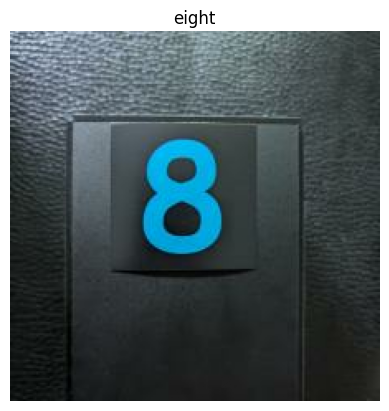

In [42]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.axis("off")
plt.title(classes[label])

In [43]:
path = "./datasets/original_128"

dataset.save(path)

### Data augmentation

In [78]:
path = "./datasets/original_128"

dataset = tf.data.Dataset.load(path)


In [79]:
len(dataset)

992

In [80]:
dataset = dataset.shuffle(1000)

In [81]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [87]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.25, fill_mode="nearest"),
    layers.RandomRotation(0.005, fill_mode="nearest"),
    layers.RandomBrightness(0.0003),
    layers.RandomContrast(0.0003)
  ]
)

Text(0.5, 1.0, 'Alphabet_x')

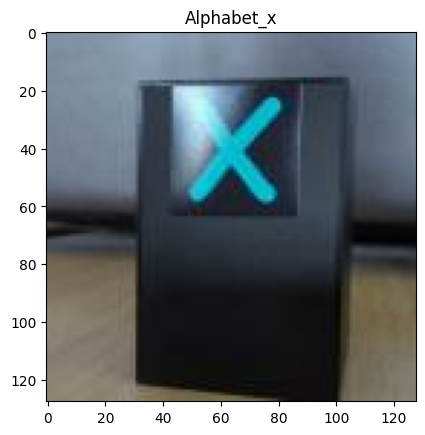

In [88]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.title(classes[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


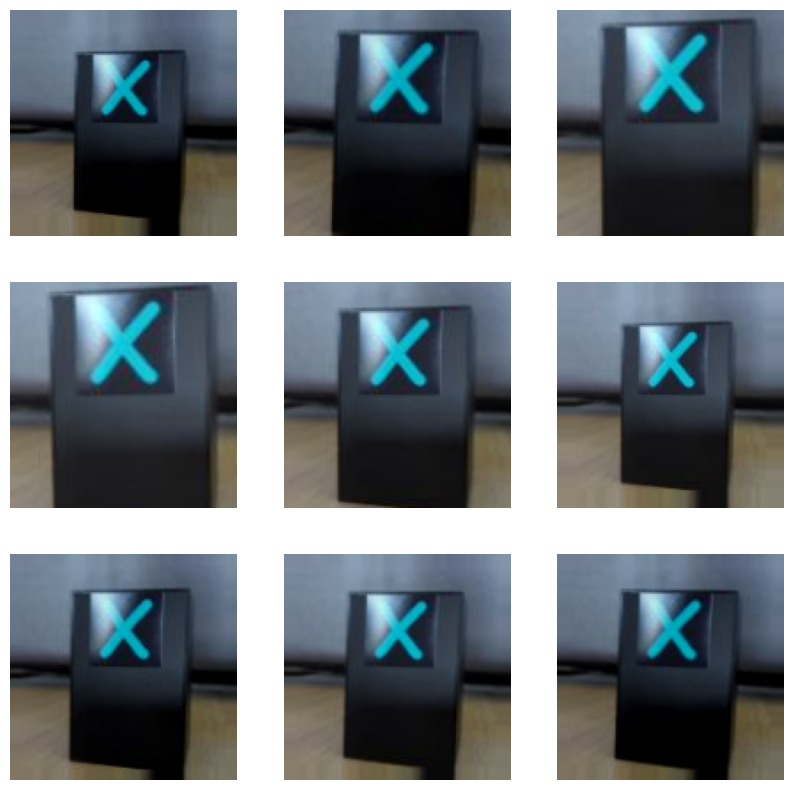

In [90]:
plt.figure(figsize=(10, 10))
for i in range(9):
  new_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(new_image)
  plt.axis("off")

### Train-test-val split

In [9]:
path = "./datasets/original_128"

full_dataset = tf.data.Dataset.load(path)


In [10]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [11]:
len(full_dataset)

992

In [12]:
full_dataset = full_dataset.shuffle(1000)

In [13]:
val_size = test_size = int(0.15*len(full_dataset))
train_size = len(full_dataset) - val_size - test_size

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print(len(train_dataset), len(val_dataset), len(test_dataset))

696 148 148


In [14]:
#check if all datasets contain all classes
train_labels = []
for image, label in train_dataset:
    train_labels.append(int(label))

print(len(np.unique(train_labels)))

val_labels = []
for image, label in val_dataset:
    val_labels.append(int(label))

print(len(np.unique(val_labels)))

test_labels = []
for image, label in test_dataset:
    test_labels.append(int(label))

print(len(np.unique(test_labels)))

31
31
31


In [15]:
batch_size = 64

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [16]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### CNN

In [14]:
img_shape = (128, 128, 3,)

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.25, fill_mode="nearest"),
    layers.RandomRotation(0.005, fill_mode="nearest"),
    layers.RandomBrightness(0.0003),
    layers.RandomContrast(0.0003)
  ]
)

Text(0.5, 1.0, 'Bullseye')

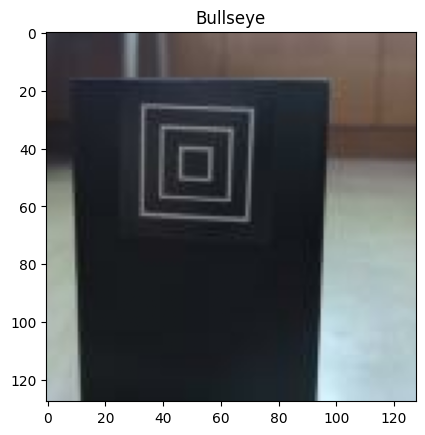

In [16]:
images, labels = next(iter(train_dataset))
plt.imshow(images[0])
plt.title(classes[labels[0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


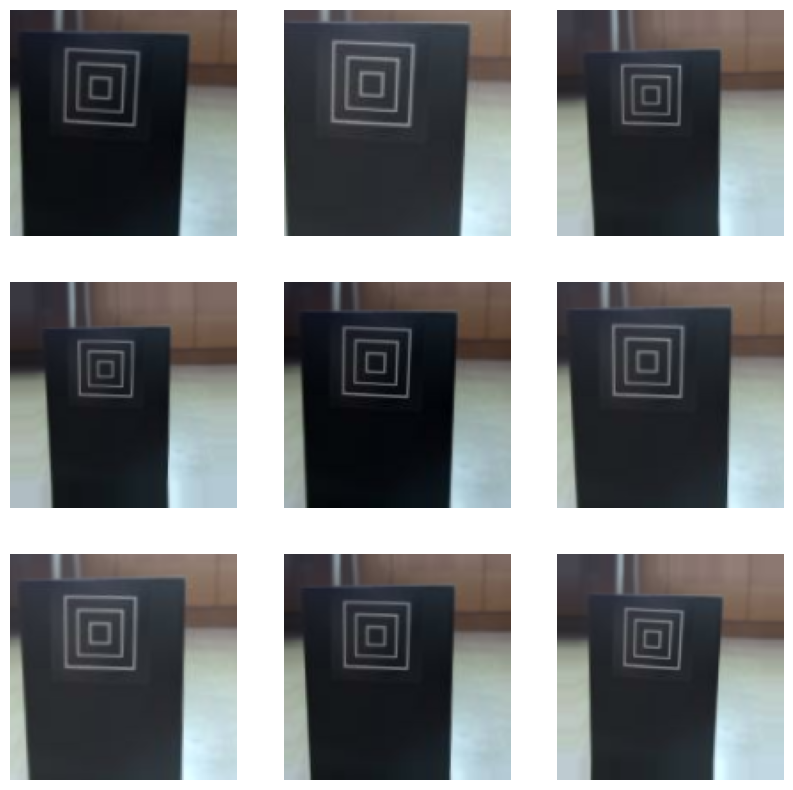

In [17]:
plt.figure(figsize=(10, 10))
for i in range(9):
  new_image = data_augmentation(images[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(new_image)
  plt.axis("off")

In [18]:
cnn_model = Sequential([
  keras.Input(shape=img_shape),
  data_augmentation,
  layers.Conv2D(12, 3, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(24, 3, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(48, 3, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling2D(),
  layers.Dense(len(classes))
])


In [19]:
import tensorflow_addons as tfa

#optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

In [20]:
cnn_model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [21]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 128, 3)             0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 12)      336       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 24)        2616      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 48)       

In [22]:
epochs = 100

history = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/100


11/11 [==============================] - 20s 1s/step - loss: 3.4367 - accuracy: 0.0388 - val_loss: 3.4315 - val_accuracy: 0.0405
Epoch 2/100
11/11 [==============================] - 11s 1s/step - loss: 3.4329 - accuracy: 0.0330 - val_loss: 3.4317 - val_accuracy: 0.0338
Epoch 3/100
11/11 [==============================] - 11s 961ms/step - loss: 3.4318 - accuracy: 0.0402 - val_loss: 3.4341 - val_accuracy: 0.0270
Epoch 4/100
11/11 [==============================] - 11s 956ms/step - loss: 3.4284 - accuracy: 0.0560 - val_loss: 3.4370 - val_accuracy: 0.0203
Epoch 5/100
11/11 [==============================] - 11s 956ms/step - loss: 3.4256 - accuracy: 0.0445 - val_loss: 3.4249 - val_accuracy: 0.0338
Epoch 6/100
11/11 [==============================] - 11s 994ms/step - loss: 3.4218 - accuracy: 0.0402 - val_loss: 3.4104 - val_accuracy: 0.0811
Epoch 7/100
11/11 [==============================] - 11s 938ms/step - loss: 3.4079 - accuracy: 0.0690 - val_loss: 3.3932 - val_accuracy: 0.0743
Epoch 8/10

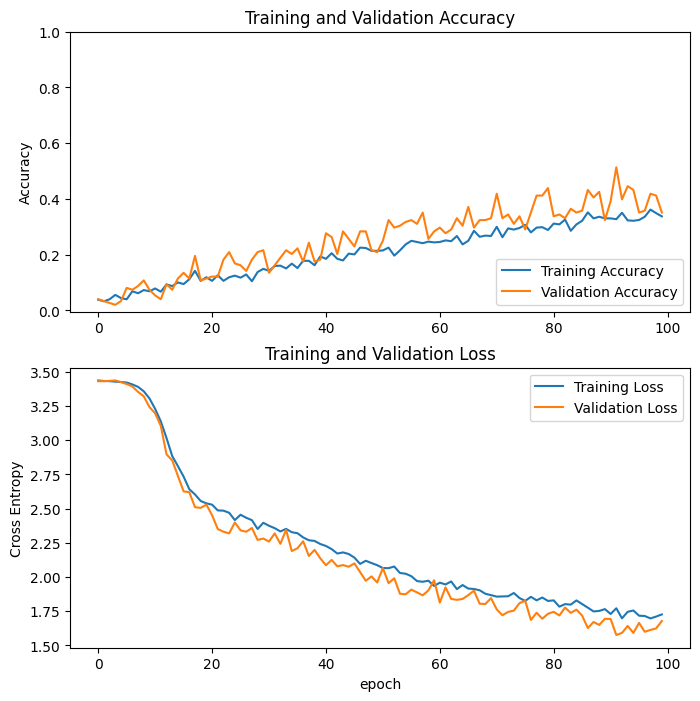

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
#train for another 300 epochs
epochs = 300

history1 = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/300


11/11 [==============================] - 11s 956ms/step - loss: 1.7080 - accuracy: 0.3261 - val_loss: 1.6665 - val_accuracy: 0.3649
Epoch 2/300
11/11 [==============================] - 11s 979ms/step - loss: 1.6398 - accuracy: 0.3549 - val_loss: 1.4653 - val_accuracy: 0.4865
Epoch 3/300
11/11 [==============================] - 11s 951ms/step - loss: 1.6981 - accuracy: 0.3233 - val_loss: 1.5846 - val_accuracy: 0.3986
Epoch 4/300
11/11 [==============================] - 11s 941ms/step - loss: 1.6778 - accuracy: 0.3477 - val_loss: 1.5070 - val_accuracy: 0.4257
Epoch 5/300
11/11 [==============================] - 11s 988ms/step - loss: 1.6382 - accuracy: 0.3635 - val_loss: 1.5494 - val_accuracy: 0.3919
Epoch 6/300
11/11 [==============================] - 12s 1s/step - loss: 1.6689 - accuracy: 0.3764 - val_loss: 1.5750 - val_accuracy: 0.4054
Epoch 7/300
11/11 [==============================] - 11s 990ms/step - loss: 1.6458 - accuracy: 0.3836 - val_loss: 1.6251 - val_accuracy: 0.4459
Epoch 8

In [25]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

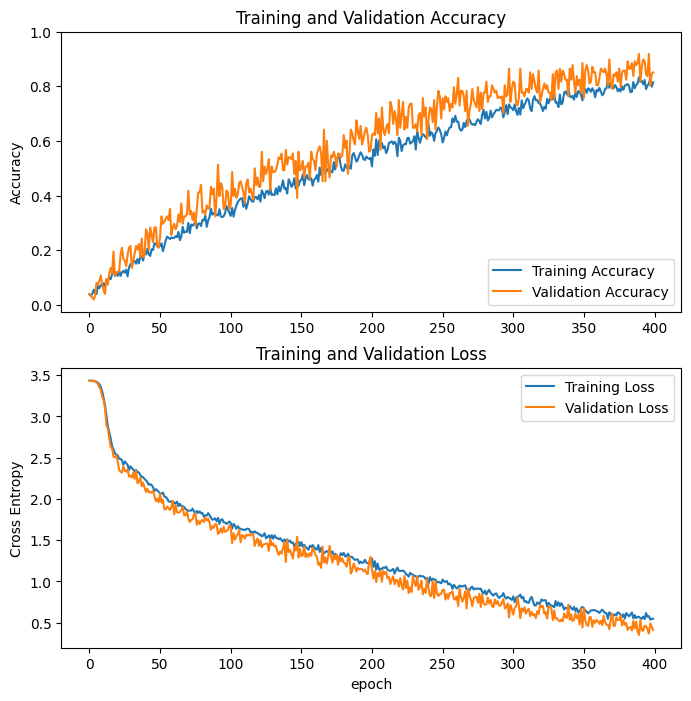

In [26]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
#train for another 300 epochs
epochs = 300

history2 = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/300


11/11 [==============================] - 11s 953ms/step - loss: 0.5492 - accuracy: 0.8060 - val_loss: 0.3933 - val_accuracy: 0.8784
Epoch 2/300
11/11 [==============================] - 10s 910ms/step - loss: 0.5196 - accuracy: 0.8132 - val_loss: 0.4316 - val_accuracy: 0.8851
Epoch 3/300
11/11 [==============================] - 11s 949ms/step - loss: 0.5411 - accuracy: 0.8348 - val_loss: 0.4202 - val_accuracy: 0.8986
Epoch 4/300
11/11 [==============================] - 10s 934ms/step - loss: 0.4905 - accuracy: 0.8420 - val_loss: 0.3836 - val_accuracy: 0.8851
Epoch 5/300
11/11 [==============================] - 10s 929ms/step - loss: 0.4872 - accuracy: 0.8362 - val_loss: 0.4004 - val_accuracy: 0.8581
Epoch 6/300
11/11 [==============================] - 11s 959ms/step - loss: 0.5307 - accuracy: 0.8161 - val_loss: 0.4244 - val_accuracy: 0.8649
Epoch 7/300
11/11 [==============================] - 10s 931ms/step - loss: 0.5271 - accuracy: 0.8305 - val_loss: 0.3961 - val_accuracy: 0.8716
Epoc

In [28]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history, history2.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

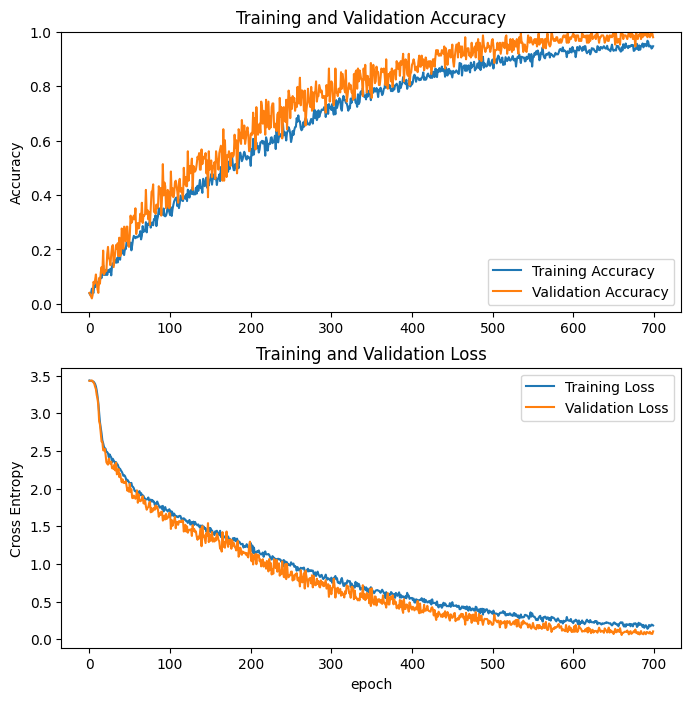

In [29]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
#train for another 50 epochs
epochs = 50

history3 = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/50


11/11 [==============================] - 11s 950ms/step - loss: 0.1805 - accuracy: 0.9483 - val_loss: 0.0790 - val_accuracy: 0.9865
Epoch 2/50
11/11 [==============================] - 10s 930ms/step - loss: 0.1751 - accuracy: 0.9497 - val_loss: 0.0982 - val_accuracy: 0.9730
Epoch 3/50
11/11 [==============================] - 11s 942ms/step - loss: 0.1739 - accuracy: 0.9497 - val_loss: 0.0669 - val_accuracy: 0.9932
Epoch 4/50
11/11 [==============================] - 11s 938ms/step - loss: 0.1956 - accuracy: 0.9382 - val_loss: 0.0640 - val_accuracy: 0.9932
Epoch 5/50
11/11 [==============================] - 10s 931ms/step - loss: 0.1986 - accuracy: 0.9325 - val_loss: 0.0577 - val_accuracy: 1.0000
Epoch 6/50
11/11 [==============================] - 10s 917ms/step - loss: 0.1602 - accuracy: 0.9612 - val_loss: 0.0547 - val_accuracy: 1.0000
Epoch 7/50
11/11 [==============================] - 10s 911ms/step - loss: 0.1754 - accuracy: 0.9483 - val_loss: 0.0670 - val_accuracy: 0.9932
Epoch 8/50

In [32]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history, history2.history, history3.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

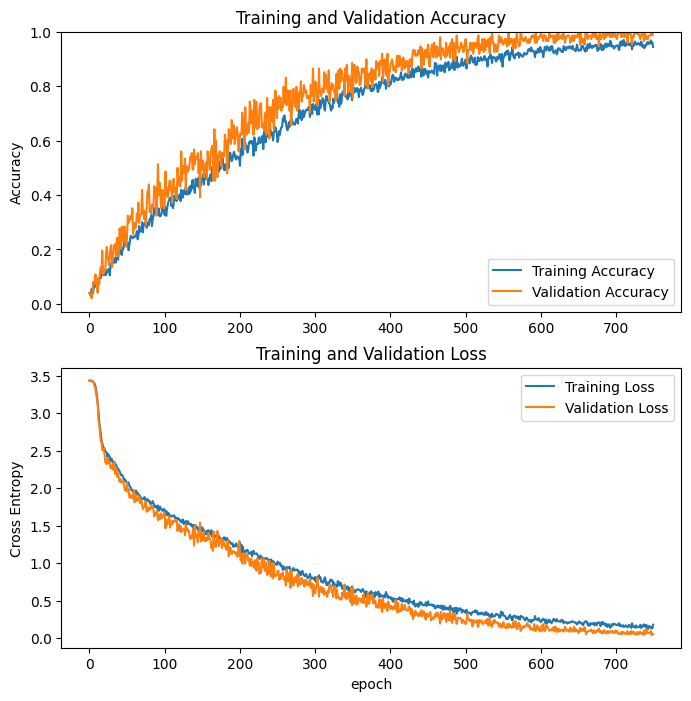

In [33]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
results = cnn_model.evaluate(test_dataset, batch_size=64)
print("test loss, test acc:", results)

3/3 [==============================] - 0s 6ms/step - loss: 0.0718 - accuracy: 0.9932
test loss, test acc: [0.07178772985935211, 0.9932432174682617]


In [56]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in test_dataset:
    test_labels += list(labels.numpy())
    pred_logits = cnn_model.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

1/1 [==============================] - 0s 48ms/step


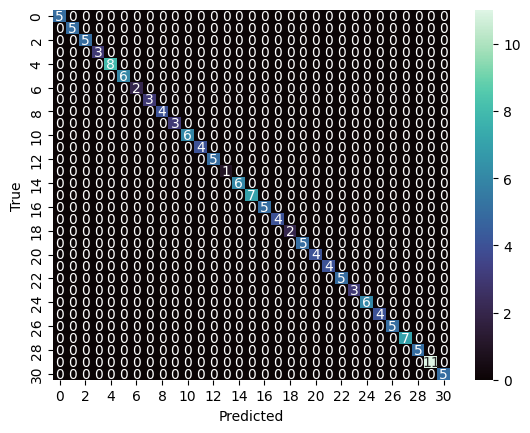

In [57]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

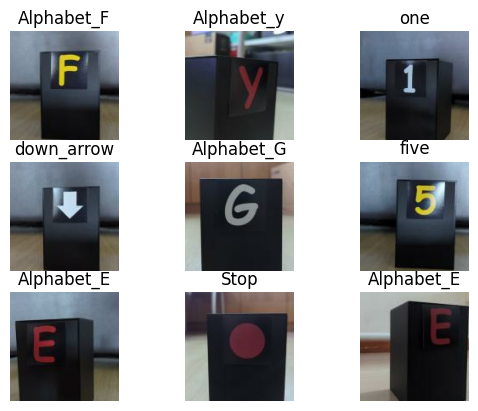

In [58]:
images, labels = next(iter(test_dataset))
preds = cnn_model(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [59]:
cnn_model.save("./models/testing/cnn_model.keras")

#### depthwise convolution

In [17]:
img_shape = (128, 128, 3,)

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.25, fill_mode="nearest"),
    layers.RandomRotation(0.005, fill_mode="nearest"),
    layers.RandomBrightness(0.0003),
    layers.RandomContrast(0.0003)
  ]
)

In [19]:
cnn_model_dw = Sequential([
  keras.Input(shape=img_shape),
  data_augmentation,
  layers.SeparableConv2D(12, 3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.SeparableConv2D(24, 3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.SeparableConv2D(48, 3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling2D(),
  layers.Dense(len(classes))
])


In [20]:
import tensorflow_addons as tfa

#optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

In [21]:
cnn_model_dw.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [22]:
cnn_model_dw.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 separable_conv2d_3 (Separab  (None, 126, 126, 12)     75        
 leConv2D)                                                       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 12)       0         
 2D)                                                             
                                                                 
 separable_conv2d_4 (Separab  (None, 61, 61, 24)       420       
 leConv2D)                                                       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                  

In [23]:
epochs = 100

history = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/100


11/11 [==============================] - 16s 946ms/step - loss: 3.4348 - accuracy: 0.0216 - val_loss: 3.4342 - val_accuracy: 0.0270
Epoch 2/100
11/11 [==============================] - 10s 900ms/step - loss: 3.4342 - accuracy: 0.0345 - val_loss: 3.4334 - val_accuracy: 0.0203
Epoch 3/100
11/11 [==============================] - 11s 941ms/step - loss: 3.4341 - accuracy: 0.0345 - val_loss: 3.4343 - val_accuracy: 0.0203
Epoch 4/100
11/11 [==============================] - 11s 946ms/step - loss: 3.4343 - accuracy: 0.0287 - val_loss: 3.4334 - val_accuracy: 0.0338
Epoch 5/100
11/11 [==============================] - 10s 911ms/step - loss: 3.4342 - accuracy: 0.0316 - val_loss: 3.4338 - val_accuracy: 0.0270
Epoch 6/100
11/11 [==============================] - 11s 936ms/step - loss: 3.4340 - accuracy: 0.0287 - val_loss: 3.4339 - val_accuracy: 0.0608
Epoch 7/100
11/11 [==============================] - 10s 897ms/step - loss: 3.4336 - accuracy: 0.0330 - val_loss: 3.4330 - val_accuracy: 0.0676
Epoc

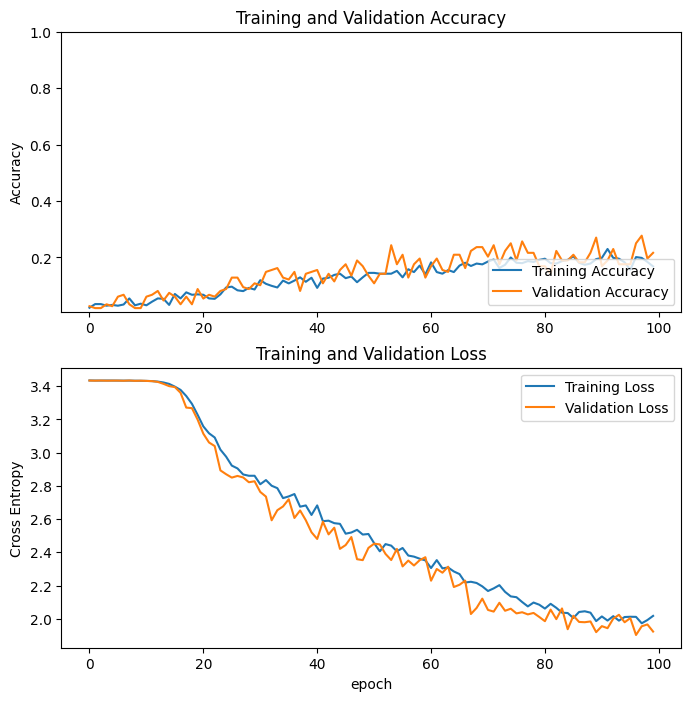

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
#increase learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.01)

cnn_model_dw.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [27]:
#train for another 200 epochs
epochs = 200

history1 = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/200


11/11 [==============================] - 14s 988ms/step - loss: 2.3638 - accuracy: 0.1566 - val_loss: 2.3149 - val_accuracy: 0.1622
Epoch 2/200
11/11 [==============================] - 11s 995ms/step - loss: 2.2378 - accuracy: 0.1595 - val_loss: 2.0726 - val_accuracy: 0.1689
Epoch 3/200
11/11 [==============================] - 11s 950ms/step - loss: 2.1488 - accuracy: 0.1695 - val_loss: 2.0664 - val_accuracy: 0.1486
Epoch 4/200
11/11 [==============================] - 11s 953ms/step - loss: 2.0838 - accuracy: 0.1710 - val_loss: 2.0233 - val_accuracy: 0.1419
Epoch 5/200
11/11 [==============================] - 11s 959ms/step - loss: 2.0526 - accuracy: 0.1825 - val_loss: 1.9085 - val_accuracy: 0.1959
Epoch 6/200
11/11 [==============================] - 10s 930ms/step - loss: 2.0110 - accuracy: 0.1853 - val_loss: 1.9613 - val_accuracy: 0.1959
Epoch 7/200
11/11 [==============================] - 12s 1s/step - loss: 1.9716 - accuracy: 0.1724 - val_loss: 1.9143 - val_accuracy: 0.2432
Epoch 8

In [28]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

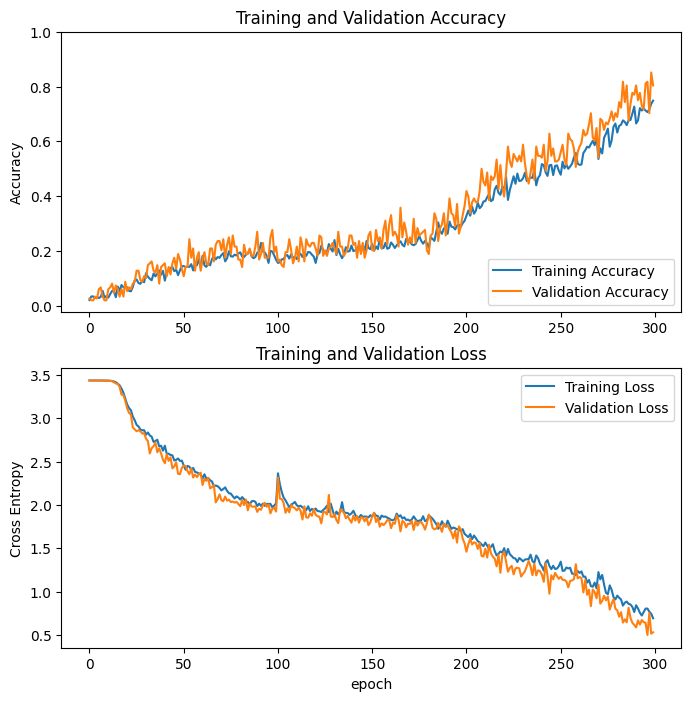

In [29]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
#train for another 100 epochs
epochs = 100

history2 = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/100


11/11 [==============================] - 11s 964ms/step - loss: 0.7026 - accuracy: 0.7328 - val_loss: 0.5106 - val_accuracy: 0.8108
Epoch 2/100
11/11 [==============================] - 10s 914ms/step - loss: 0.7171 - accuracy: 0.7385 - val_loss: 0.4484 - val_accuracy: 0.8649
Epoch 3/100
11/11 [==============================] - 10s 887ms/step - loss: 0.6424 - accuracy: 0.7816 - val_loss: 0.6416 - val_accuracy: 0.8108
Epoch 4/100
11/11 [==============================] - 10s 916ms/step - loss: 0.6793 - accuracy: 0.7701 - val_loss: 0.5235 - val_accuracy: 0.8378
Epoch 5/100
11/11 [==============================] - 10s 886ms/step - loss: 0.6169 - accuracy: 0.7787 - val_loss: 0.4524 - val_accuracy: 0.8514
Epoch 6/100
11/11 [==============================] - 10s 918ms/step - loss: 0.7022 - accuracy: 0.7385 - val_loss: 0.6217 - val_accuracy: 0.7973
Epoch 7/100
11/11 [==============================] - 10s 923ms/step - loss: 0.7312 - accuracy: 0.7486 - val_loss: 0.5130 - val_accuracy: 0.8311
Epoc

In [31]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history, history2.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

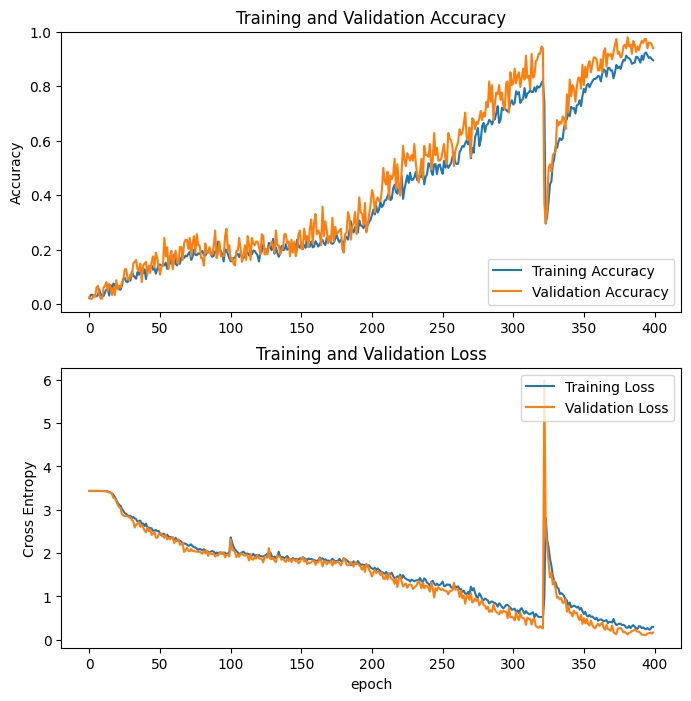

In [32]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
#decrease learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)

cnn_model_dw.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [34]:
#train for another 200 epochs
epochs = 100

history3 = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/100


11/11 [==============================] - 14s 951ms/step - loss: 0.2317 - accuracy: 0.9167 - val_loss: 0.1013 - val_accuracy: 0.9730
Epoch 2/100
11/11 [==============================] - 11s 959ms/step - loss: 0.1919 - accuracy: 0.9253 - val_loss: 0.0714 - val_accuracy: 0.9932
Epoch 3/100
11/11 [==============================] - 10s 908ms/step - loss: 0.1921 - accuracy: 0.9325 - val_loss: 0.0851 - val_accuracy: 0.9797
Epoch 4/100
11/11 [==============================] - 10s 922ms/step - loss: 0.1778 - accuracy: 0.9353 - val_loss: 0.1089 - val_accuracy: 0.9730
Epoch 5/100
11/11 [==============================] - 10s 899ms/step - loss: 0.1621 - accuracy: 0.9526 - val_loss: 0.0683 - val_accuracy: 0.9865
Epoch 6/100
11/11 [==============================] - 10s 897ms/step - loss: 0.1873 - accuracy: 0.9296 - val_loss: 0.0824 - val_accuracy: 0.9730
Epoch 7/100
11/11 [==============================] - 10s 905ms/step - loss: 0.1524 - accuracy: 0.9483 - val_loss: 0.0696 - val_accuracy: 1.0000
Epoc

In [35]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history, history2.history, history3.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

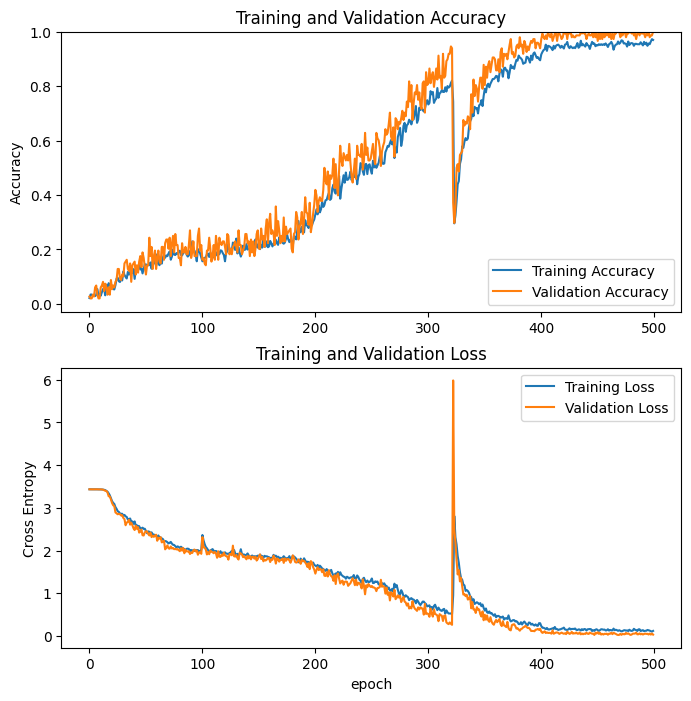

In [36]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
results = cnn_model_dw.evaluate(test_dataset, batch_size=32)
print("test loss, test acc:", results)

3/3 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9932
test loss, test acc: [0.030888879671692848, 0.9932432174682617]


In [38]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in test_dataset:
    test_labels += list(labels.numpy())
    pred_logits = cnn_model_dw.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

1/1 [==============================] - 0s 53ms/step


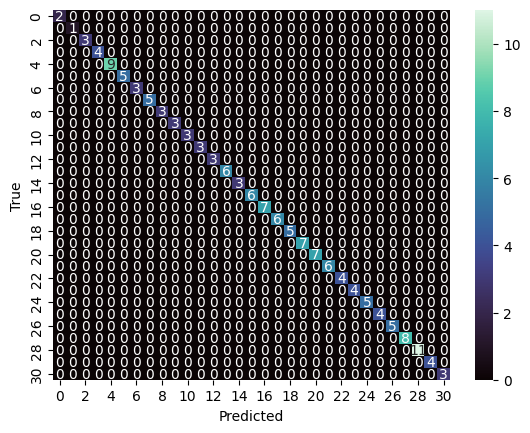

In [39]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

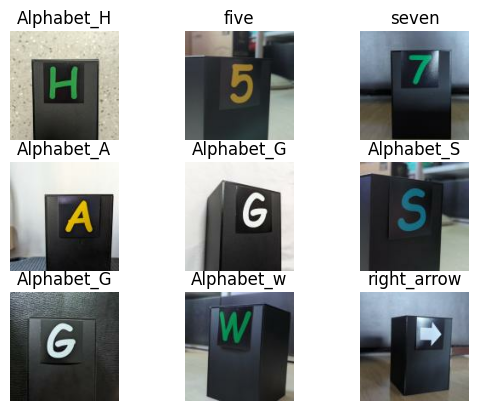

In [40]:
images, labels = next(iter(test_dataset))
preds = cnn_model_dw(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [41]:
cnn_model_dw.save("./models/testing/cnn_model_dw.keras")

### Finetune pretrained model

In [88]:
img_shape = (128, 128, 3)

In [89]:
mobnetv3 = keras.applications.MobileNetV3Small(
  input_shape=img_shape,
  classes=len(classes),
  include_top=False,
  weights='imagenet',
  pooling=None,
  include_preprocessing=True
)

In [90]:
mobnetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 128, 128, 3)  0           ['input_10[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 64, 64, 16)   432         ['rescaling_7[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 64, 64, 16)  64          ['Conv[0][0]']    

In [91]:
len(mobnetv3.layers)

229

In [92]:
for layer in mobnetv3.layers:
    layer.trainable = True


In [93]:
mobnetv3_ft = keras.Sequential([
  keras.Input(shape=img_shape), 
  data_augmentation,
  layers.Rescaling(255),
  mobnetv3,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),
  layers.Dense(len(classes))
])

In [94]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = mobnetv3_ft(image_batch)
print(feature_batch.shape)

(64, 31)


In [95]:
mobnetv3_ft.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_6   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 576)               0         
                                                                 
 dense_8 (Dense)             (None, 31)               

In [96]:
import tensorflow_addons as tfa

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.0001)

In [97]:
mobnetv3_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [98]:
epochs = 100

history_mobnet = mobnetv3_ft.fit(train_dataset,
                                epochs=epochs,
                                validation_data=val_dataset)

Epoch 1/100


11/11 [==============================] - 18s 1s/step - loss: 4.0907 - accuracy: 0.0273 - val_loss: 4.1545 - val_accuracy: 0.0338
Epoch 2/100
11/11 [==============================] - 11s 950ms/step - loss: 3.7580 - accuracy: 0.0546 - val_loss: 3.9252 - val_accuracy: 0.0203
Epoch 3/100
11/11 [==============================] - 10s 920ms/step - loss: 3.5479 - accuracy: 0.0632 - val_loss: 3.7557 - val_accuracy: 0.0270
Epoch 4/100
11/11 [==============================] - 10s 913ms/step - loss: 3.4572 - accuracy: 0.0632 - val_loss: 3.5755 - val_accuracy: 0.0338
Epoch 5/100
11/11 [==============================] - 10s 921ms/step - loss: 3.3835 - accuracy: 0.0805 - val_loss: 3.5700 - val_accuracy: 0.0405
Epoch 6/100
11/11 [==============================] - 11s 934ms/step - loss: 3.2427 - accuracy: 0.0934 - val_loss: 3.5001 - val_accuracy: 0.0405
Epoch 7/100
11/11 [==============================] - 10s 896ms/step - loss: 3.1314 - accuracy: 0.1193 - val_loss: 3.4637 - val_accuracy: 0.0541
Epoch 8

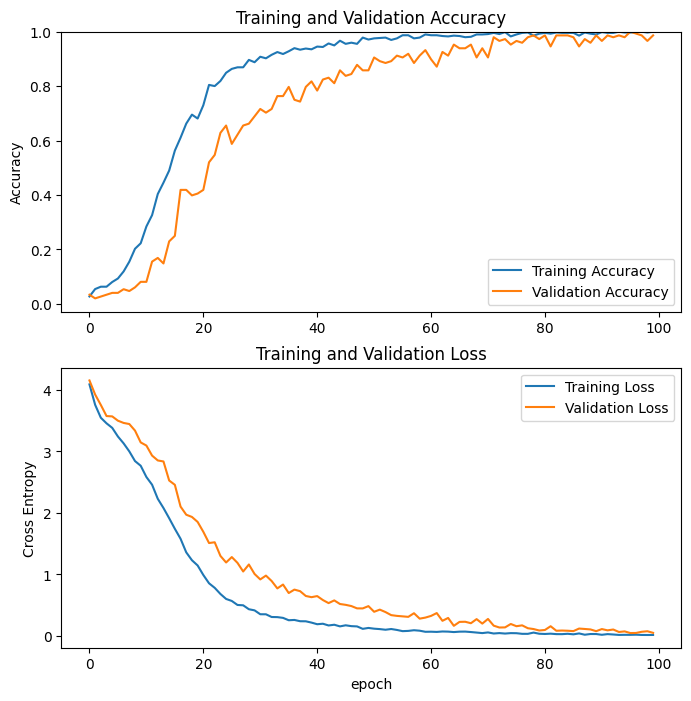

In [99]:
acc = history_mobnet.history['accuracy']
val_acc = history_mobnet.history['val_accuracy']

loss = history_mobnet.history['loss']
val_loss = history_mobnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [101]:
loss, accuracy = mobnetv3_ft.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 13ms/step - loss: 0.0391 - accuracy: 0.9932
Test accuracy : 0.9932432174682617


In [102]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in test_dataset:
    test_labels += list(labels.numpy())
    pred_logits = mobnetv3_ft.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

1/1 [==============================] - 1s 513ms/step


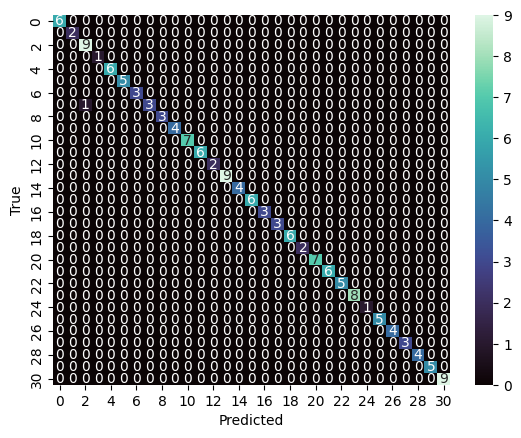

In [103]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

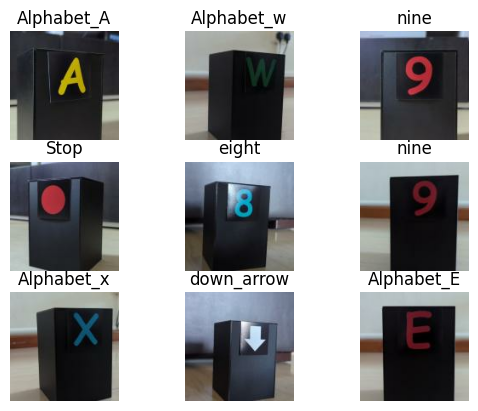

In [104]:
images, labels = next(iter(test_dataset))
preds = mobnetv3_ft(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [105]:
mobnetv3_ft.save("./models/testing/mobnetv3_ft.keras")

##### effnet

In [74]:
effnetv2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    include_preprocessing=True
)

In [75]:
effnetv2.trainable = True

In [76]:
effnetv2.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 128, 128, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  0           ['rescaling_5[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 32)   864         ['normalization[0

In [78]:
effnetv2_ft = keras.Sequential([
  keras.Input(shape=img_shape), 
  data_augmentation,
  layers.Rescaling(255),
  effnetv2,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),
  layers.Dense(len(classes))
])

In [80]:
effnetv2_ft.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 31)               

In [81]:
import tensorflow_addons as tfa

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)

In [82]:
effnetv2_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
epochs = 50

history = effnetv2_ft.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/50


11/11 [==============================] - 23s 1s/step - loss: 3.4776 - accuracy: 0.0460 - val_loss: 3.4008 - val_accuracy: 0.0608
Epoch 2/50
11/11 [==============================] - 12s 1s/step - loss: 3.2935 - accuracy: 0.1092 - val_loss: 3.1752 - val_accuracy: 0.1622
Epoch 3/50
11/11 [==============================] - 11s 961ms/step - loss: 3.0098 - accuracy: 0.2155 - val_loss: 2.7943 - val_accuracy: 0.3919
Epoch 4/50
11/11 [==============================] - 11s 995ms/step - loss: 2.7236 - accuracy: 0.3894 - val_loss: 2.3451 - val_accuracy: 0.6351
Epoch 5/50
11/11 [==============================] - 11s 965ms/step - loss: 2.2948 - accuracy: 0.5963 - val_loss: 1.7805 - val_accuracy: 0.8446
Epoch 6/50
11/11 [==============================] - 11s 1s/step - loss: 1.7904 - accuracy: 0.7615 - val_loss: 1.2734 - val_accuracy: 0.9122
Epoch 7/50
11/11 [==============================] - 11s 964ms/step - loss: 1.3379 - accuracy: 0.8549 - val_loss: 0.9430 - val_accuracy: 0.9054
Epoch 8/50
11/11 [=

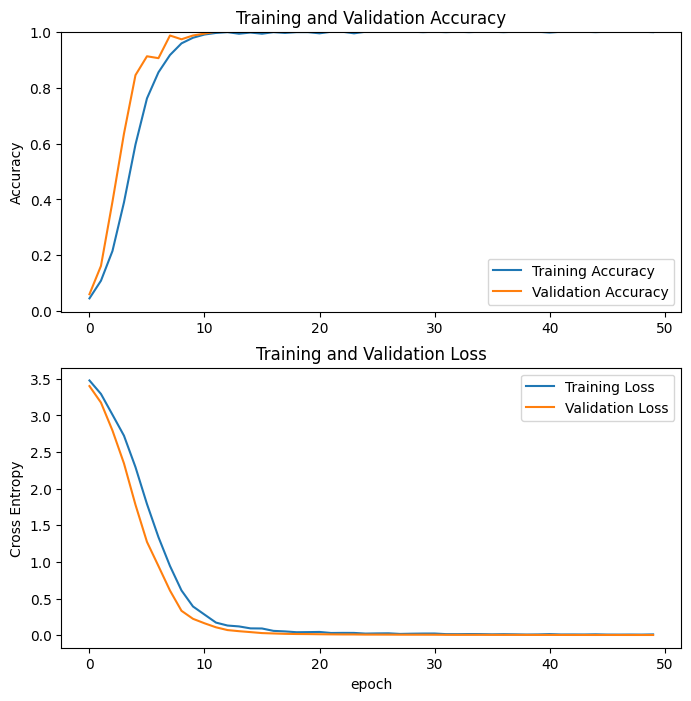

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [85]:
loss, accuracy = effnetv2_ft.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 25ms/step - loss: 0.0022 - accuracy: 1.0000
Test accuracy : 1.0


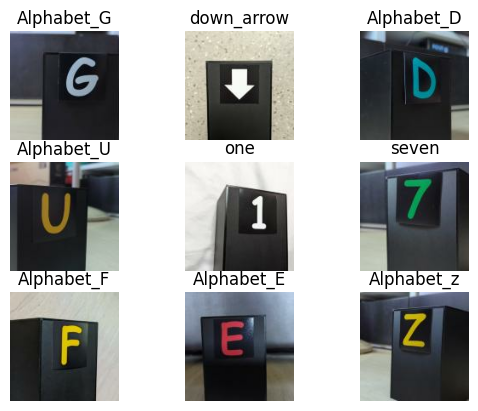

In [86]:
images, labels = next(iter(test_dataset))
preds_logits = effnetv2_ft(images)
preds = tf.math.argmax(preds_logits, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [87]:
mobnetv3_ft.save("./models/testing/effnetv2_ft.keras")